# Project : Bahasa Isyarat Indonesia (BISINDO) Classification 2

*revisi project sebelumnya karena akurasi rendah dengan cara menambah dataset* 
- multiclass classification
- dataset : [link](https://www.kaggle.com/datasets/achmadnoer/alfabet-bisindo)

## Import Libary

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import zipfile,os

# handling image 
import cv2
import random 
from keras.preprocessing import image

from string import ascii_uppercase

## Data preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# melakukan ekstraksi pada file zip    
local_zip = 'drive/MyDrive/ML/1_Dataset_Bisindo.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## Data Exploratory

### jumlah dataset

<BarContainer object of 26 artists>

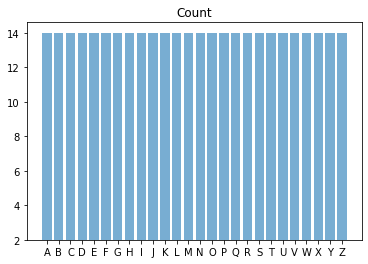

In [ ]:
alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('/tmp/Citra BISINDO/'+az, f)) for f in os.listdir('/tmp/Citra BISINDO/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

- dari gambar diatas dataset kita terdiri atas 26 label dengan jumlah data +- 14X26 = 364 gambar
- tiap label terdiri atas +- 14 gambar

### Show examples of images dataset

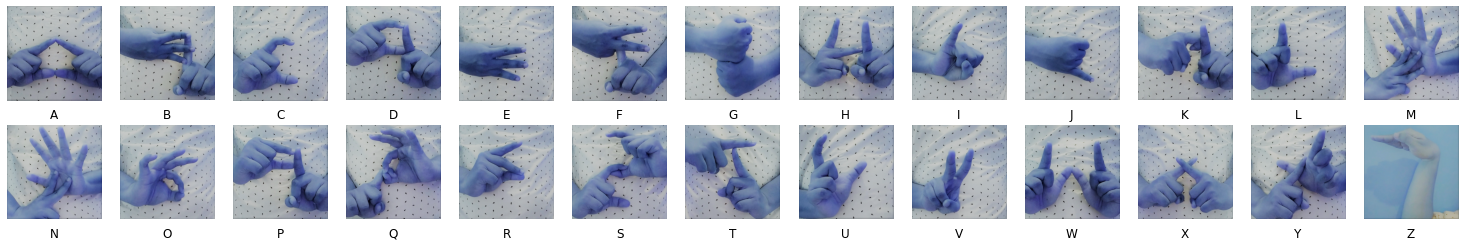

In [ ]:
sample_images = []

for folder in sorted(os.listdir('/tmp/Citra BISINDO/')):
    for image_inside in os.listdir(f'/tmp/Citra BISINDO/{folder}'):
        # selector = random.randint(1, index-1) 
        selector = image_inside

        temp_img = cv2.imread(f'/tmp/Citra BISINDO/{folder}/{selector}')
        sample_images.append(temp_img)
        break 


row = 2
col = 13
fig = plt.figure(figsize = (col*2,row*2))
for load_samples in range(0,row*col):
    fig.add_subplot(row, col, load_samples+1)
    plt.axis('off')
    plt.imshow(sample_images[load_samples])
    label = chr(load_samples+65)
    plt.title(label, y=-0.25)
plt.show()

### cek images shape

In [ ]:
tmpImgDir = '/tmp/Citra BISINDO/A/body dot (1).jpg'
img1 = cv2.imread(tmpImgDir, cv2.IMREAD_UNCHANGED)
 
# get dimensions of image
dimensions = img1.shape  

# height, width, number of channels in image
height = img1.shape[0]
width = img1.shape[1]
channels = img1.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (858, 857, 3)
Image Height       :  858
Image Width        :  857
Number of Channels :  3


### Explaination

- dataset 1:1 image dengan ukuran 858x857 bewarna
- dari sumber dataset, gambar difoto menggunakan 3 background yg berbeda yaitu
  - a plain white shirt, 
  - a white wall, 
  - a white dot-patterned shirt
- jarak objek dengan lensa kamera kurang lebih 70 cm

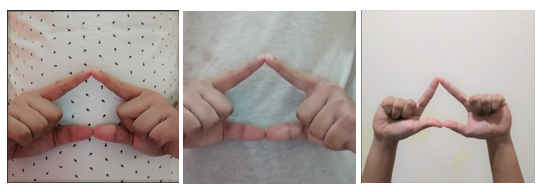

## Data Preprocessing

### Augmented dataset
- karena jumlah dataset kita terlalu kecil maka terlebih dahulu kita tambah menggunakan augmentasi

1. Define image generator untuk menentukan augmentasi yg akan diterapkan pada dataset gambar

In [ ]:
datagen = ImageDataGenerator(
                    rotation_range =15, 
                    width_shift_range = 0.2, 
                    height_shift_range = 0.2,  
                    shear_range=0.2, 
                    zoom_range=0.2, 
                    fill_mode = 'nearest', 
                    brightness_range=[0.5, 1.5]
) 

2. terapkan augmentasi `datagen` pada tiap gambar maksimal hasil augmentasi adalah 5 untuk tiap 1 gambar

In [ ]:
for folder in alphabets:
  for f in os.listdir('/tmp/Citra BISINDO/'+folder):
    filename='/tmp/Citra BISINDO/'+folder+'/'+f

    img = load_img(filename)
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0

    # generate 5 new augmented images 
    for batch in datagen.flow(x, batch_size = 1, 
                      save_to_dir ='/tmp/Citra BISINDO/'+folder,  
                      save_prefix ='aug', save_format ='jpg'):
        i += 1
        if i > 5: 
            break

3. membuat **Checkpoint**
kita simpan dataset kita yg baru dari hasil augmented, untuk digunakan kembali berhubung proses augmentednya lama jika diulang kembali


- sebelum itu, kita buat jadi zip agar ukurannya tidak terlalu besar

In [ ]:
# zip folder 'citra bisindo' dengan nama file alphabets_augmented.zip

!zip -r /tmp/alphabets_augmented.zip /tmp/Citra\ BISINDO

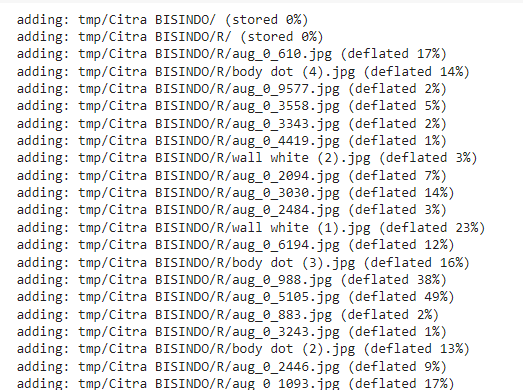

- copy hasil augmentasinya ke drive

In [ ]:
# linux command to copy files or directories
# copy /tmp/Citra BISINTO -> /drive/MyDrive/ML/

!cp -r /tmp/alphabets_augmented.zip /content/drive/MyDrive/ML/

5. cek lagi jumlah dataset

<BarContainer object of 26 artists>

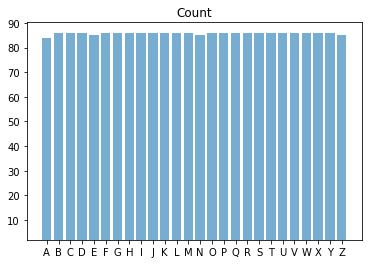

In [ ]:
from string import ascii_uppercase

alphabets = [az for az in ascii_uppercase]
counts = [sum(os.path.isfile(os.path.join('/tmp/Citra BISINDO/'+az, f)) for f in os.listdir('/tmp/Citra BISINDO/'+az)) for az in ascii_uppercase]

plt.title('Count')
plt.bar(alphabets, counts, alpha=0.6, bottom=2, linewidth=2)

- dataset nya telah bertambah dari sebelumnya 14 tiap label menjadi 80 lebih sehingga total datasetnya +- sekitar 2.080

### Split dataset

1. split folder menjadi folder train dan val kemudian copy dataset kesetiap folder dengan rasio 8:2

In [ ]:
splitfolders.ratio('/tmp/Citra BISINDO/', output="/content/split", seed=1, ratio=(.8, .2))
base_dir = '/content/split/'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'val')

Copying files: 2179 files [00:00, 2700.30 files/s]


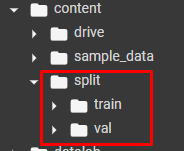

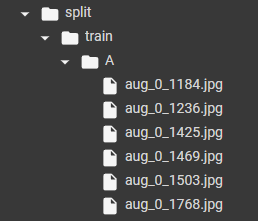

2. membuat augmentasi lagi namun hanya untuk mendefiniskan directory source data set training dan validation

- other augmentations have been done before to handle lack of data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'categorical', 
    shuffle=True
) 

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'categorical',
    shuffle=True 
)

Found 1737 images belonging to 26 classes.
Found 442 images belonging to 26 classes.


3. mengecek lagi komposisi dataset kita untuk memastikan data terbagi sesuai dengan tahap 1

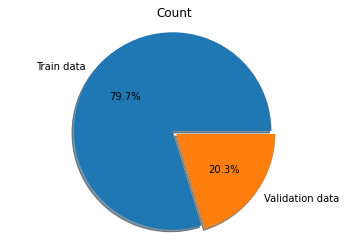

In [ ]:
labels = ['Train data', 'Validation data']
values = [len(train_generator.filenames), len(validation_generator.filenames)]
plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True, explode=(0, 0.05))
plt.axis('equal')
plt.title('Count')
plt.show()

## Modeling

1. Build Arsitektur model

In [ ]:
def custom_model():
    model = Sequential()

    # 1st CNN layer
    model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=(150, 150 ,3) ))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # 2nd CNN layer
    model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # 3rd CN Layer
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # 4th CNN Layer
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())

    # 1st Fully connected layer
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.20))

    # output layer
    model.add(Dense(26, activation = 'softmax'))

    model.summary()

    return model

In [ ]:
model = custom_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)      

2. compile model
  - loss : categorical_crossentropy
  - optimizer : adam
  - metrics : accuracy

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

3. define callback, model checkpoint save, 

In [ ]:
best_model_path = 'model.h5'

chp_callback = ModelCheckpoint(best_model_path,
                               monitor='val_accuracy',
                               save_best_only=True,
                               verbose=5)
rdc_callback = ReduceLROnPlateau(monitor='val_accuracy',
                                 patience=3,
                                 factor=0.5,
                                 min_lr=0.001,
                                 verbose=5)
callbacks_list = [chp_callback, rdc_callback]

4. training model

  - epoch : 50 

In [ ]:
# Fit model
batch_size = 64

history=model.fit(
      train_generator,
      steps_per_epoch=len(train_generator.filenames) // batch_size,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=len(validation_generator.filenames) // batch_size,
      callbacks=callbacks_list
      )

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 3.2748 - accuracy: 0.0259
Epoch 1: val_accuracy improved from -inf to 0.05833, saving model to model.h5
27/27 [==============================] - 30s 662ms/step - loss: 3.2748 - accuracy: 0.0259 - val_loss: 3.2596 - val_accuracy: 0.0583 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 3.2545 - accuracy: 0.0630
Epoch 2: val_accuracy did not improve from 0.05833
27/27 [==============================] - 19s 717ms/step - loss: 3.2545 - accuracy: 0.0630 - val_loss: 3.2337 - val_accuracy: 0.0583 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 3.2210 - accuracy: 0.0577
Epoch 3: val_accuracy improved from 0.05833 to 0.07500, saving model to model.h5
27/27 [==============================] - 17s 628ms/step - loss: 3.2210 - accuracy: 0.0577 - val_loss: 3.1090 - val_accuracy: 0.0750 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 2.926

5. show accuracy history diagram 

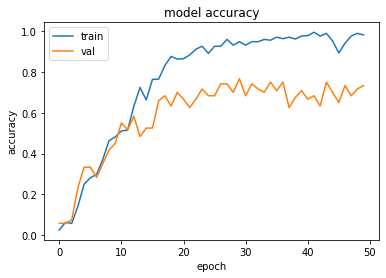

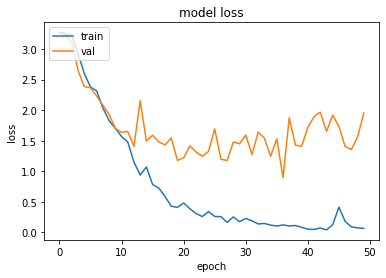

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Evaluated

1. define new image generator
  - shuffle : false (buat false agar confusion matrix tidak bingung)

In [ ]:
validation_generator1 = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'categorical',
    shuffle=False 
)

Found 442 images belonging to 26 classes.


In [ ]:
# evaluate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import itertools

from keras.preprocessing import image
import tensorflow as tf

### Confusion Matrix

In [ ]:
import numpy
test_steps_per_epoch = np.math.ceil(validation_generator1.samples / validation_generator1.batch_size)
predictions = model.predict(validation_generator1, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
true_classes = validation_generator1.classes
class_labels = list(validation_generator1.class_indices.keys())

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           A       0.63      0.71      0.67        17
           B       0.78      0.82      0.80        17
           C       0.68      0.76      0.72        17
           D       0.50      0.76      0.60        17
           E       0.62      0.47      0.53        17
           F       0.79      0.65      0.71        17
           G       0.82      0.82      0.82        17
           H       0.91      0.59      0.71        17
           I       0.57      0.71      0.63        17
           J       0.45      0.88      0.60        17
           K       0.75      0.71      0.73        17
           L       1.00      0.47      0.64        17
           M       0.61      0.65      0.63        17
           N       0.57      0.76      0.65        17
           O       0.92      0.65      0.76        17
           P       0.92      0.65      0.76        17
           Q       0.73      0.65      0.69        17
           R       0.58    

### Confusion Matrix Grafik

In [ ]:
# show the confusion matrix of our predictions

def plot_confusion2(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=True ):
    
    if normalize :
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2. if normalize else cm.max() / 1.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
def f1score_conf(model,val_gen):

  # y_pred = [np.argmax(probas) for probas in predictions]
  # y_test = validation_generator_4.classes
  class_names = val_gen.class_indices.keys()

  test_generator =  val_gen
  y_true = test_generator.classes
  y_hat =  model.predict(test_generator)
  y_hat = tf.argmax(y_hat, axis = 1).numpy()
  f1 = f1_score(y_true, y_hat, average='micro')
  print('f1 score {}'.format(f1))
    
  cnf_matrix = confusion_matrix(y_true = y_true, y_pred = y_hat) 

  plot_confusion2(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
  plot_confusion2(cnf_matrix, classes=class_names, title='confusion matrix', normalize=False)

f1 score 0.7081447963800905


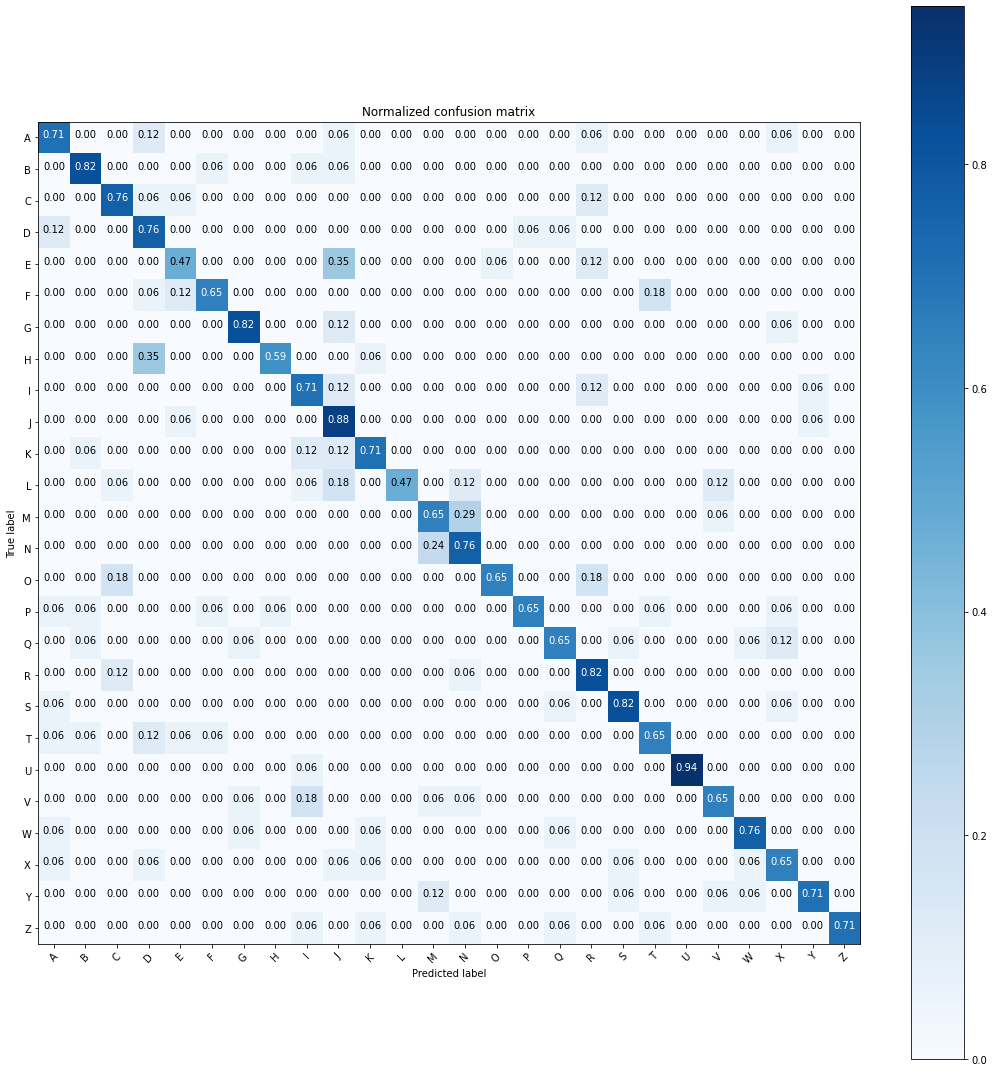

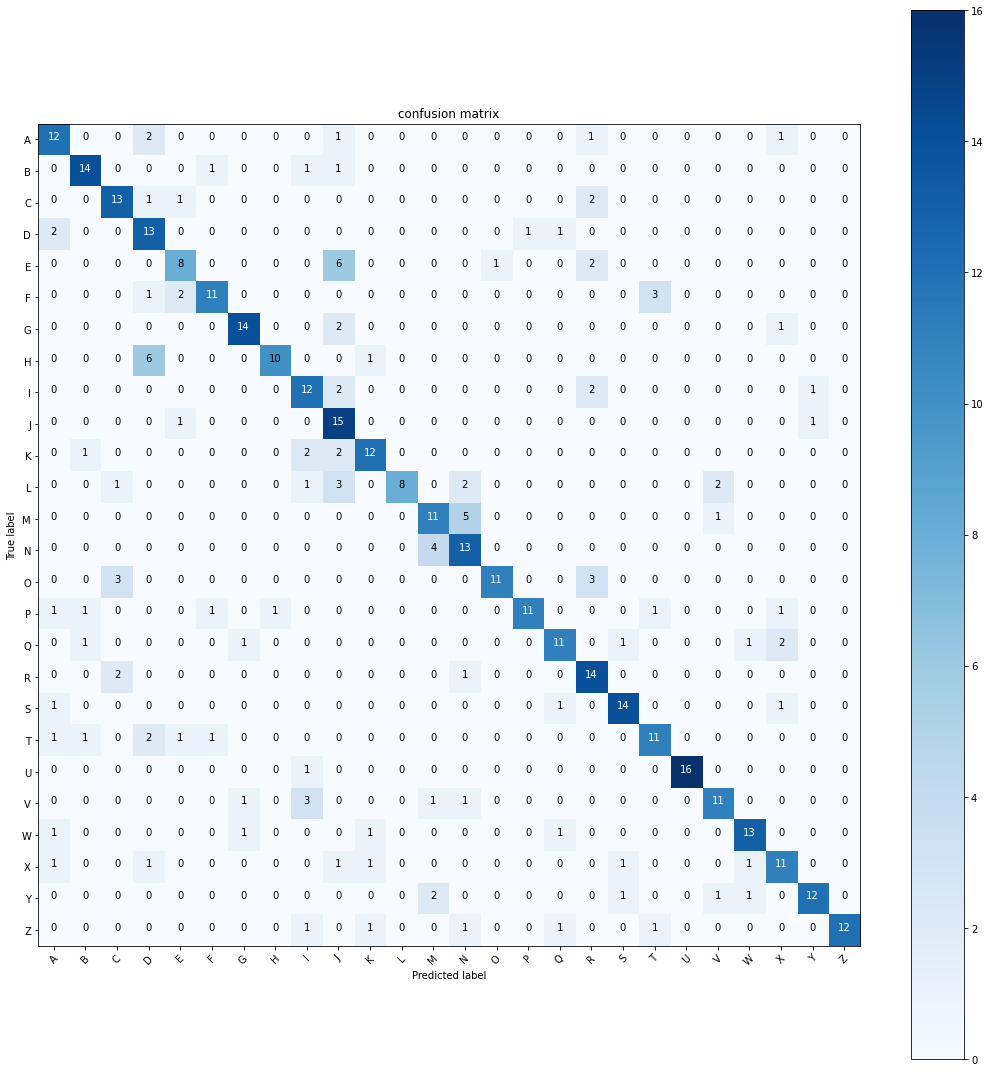

In [ ]:
f1score_conf(model,validation_generator1)

## Deployment

In [ ]:
labels = ['A','B','C','D','E','F',
          'G','H','I','J','K','L',
          'M','N','O','P','Q','R',
          'S','T','U','V','W','X',
          'Y','Z']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# It can be used to reconstruct the model identically.
model = keras.models.load_model("/content/drive/MyDrive/ML/model_bisindo_3.h5")

### Ways 1
- image classification from local image

In [ ]:
def predict(img):
    img = tf.keras.preprocessing.image.load_img(img, target_size=(150,150))
    x = tf.keras.preprocessing.image.img_to_array(img)/255.
    x = np.expand_dims(x, axis=0)

    result = model.predict(x)
    label = labels[np.argmax(result[0])]

    imgplot = plt.imshow(img)
    print("Label Predicted : ",label)

Label Predicted :  B


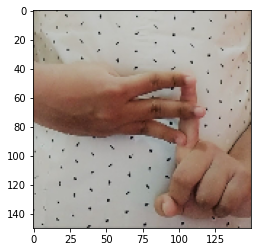

In [ ]:
img = '/tmp/Citra BISINDO/B/body dot (1).jpg'
predict(img)

### Ways 2 
- Real Time Classification using video stream 

In [ ]:
# Import Libaraires 

from IPython.display import display, Javascript, Image,clear_output
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# Initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# Function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# Function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# Defining function to detect face
def face_detect():
  import cv2
  from PIL import Image
  import numpy as np
  import os
  from keras.models import load_model
  from time import sleep
  from keras.preprocessing.image import img_to_array
  from keras.preprocessing import image
# start streaming video from webcam
  video_stream()
# label for video
  label_html = 'Capturing...'
# initialze bounding box to empty
  bbox = ''
  count = 0
  face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # Face Detection

  classifier =load_model('/content/drive/MyDrive/ML/model_bisindo_3.h5')  #Load model
  emotion_labels = labels

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = img

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    
    roi_gray = cv2.resize(gray,(150,150),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction

    roi = img_to_array(roi_gray)/255. 

    roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction 

    prediction = classifier.predict(roi)[0]   #Prediction

    label =emotion_labels[prediction.argmax()]

    cv2.putText(bbox_array,label,(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

    # test image yg tercapture
    # imgplot = plt.imshow(img)

In [ ]:
#Finally detecting the face with live webcam
face_detect()

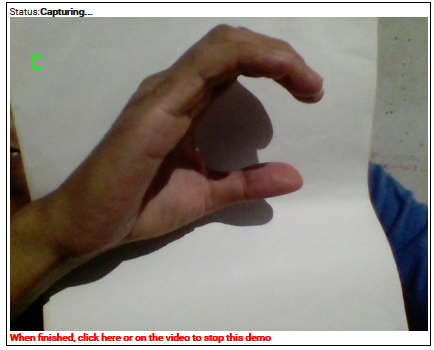

## Kesimpulan